In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [2]:

try:
  import pynumdiff
except:
  !pip install git+https://github.com/florisvb/PyNumDiff
  import pynumdiff

  Cloning https://github.com/florisvb/PyNumDiff to /tmp/pip-req-build-m4yykrq6
  Running command git clone --filter=blob:none --quiet https://github.com/florisvb/PyNumDiff /tmp/pip-req-build-m4yykrq6
  Resolved https://github.com/florisvb/PyNumDiff to commit 842f2232f9a5805a4cdcc79ed7024980a774ada5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pynumdiff: filename=pynumdiff-0.3.dev21+g842f2232f-py3-none-any.whl size=63647 sha256=caa479c9390f4148d5bee183291ffe727606511170591c7a0496b545a7337610
  Stored in directory: /tmp/pip-ephem-wheel-cache-8nbaab2g/wheels/d5/d2/d5/e088d09db33998cc8a03da8ed5da944b4512c71615c0dc9e72
Successfully built pynumdiff


In [3]:
try:
  import pysindy as ps
except:
  #!pip install git+https://github.com/dynamicslab/pysindy
  !pip install pysindy[miosr]
  import pysindy as ps

from packaging.version import Version
if Version(ps.__version__) < Version("2.0.0"):
  raise ValueError("pysindy version is: " + ps.__version__ + "This notebook uses syntax that requires pysindy 2.0 or greater.")
else:
  print("pysindy version is: " + ps.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 10.9 MB/s eta 0:00:00
pysindy version is: 2.0.0


In [4]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 1.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-hxchhb6m
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-hxchhb6m
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=3dba493b56a3c3a9f9db90b8e9406e7caa40d5034bae89296e3674c56ef1325c
  Stored in directory: /tmp/pip-ephem-wheel-cache-pry775s3/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [5]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')

pysindy_utility = import_local_or_github('pysindy_utility', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Planar drone dynamics

Now we will not include k as a static state. Instead, we will be using SINDy to find all the parameter values, which includes k.

#### Given the planar drone dynamics

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[lightblue]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[lightblue]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[lightblue]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

#### Consider the following sensor combinations:

$
\mathbf{y_c} = \mathbf{{h_c}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}}   \\[0.3em]
\ddot{x} = -\bbox[lightblue]{k} \sin(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_1} / \bbox[lightblue]{m}  \\[0.3em]
\ddot{z} = -\bbox[lightblue]{g} + \bbox[lightblue]{k} \cos(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_2}/ \bbox[lightblue]{m}
\end{bmatrix}
$

# Download, load, clean, and apply noise to data

In [6]:
generate_training_data_utility.download_data('planar_drone_trajectories.zip')
traj_list = generate_training_data_utility.load_trajectory_data('planar_drone_trajectories')
traj_list = generate_training_data_utility.clean_trajectory_data(traj_list)
traj_list = generate_training_data_utility.add_noise_to_trajectory_data(traj_list, 0.02)

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/planar_drone_trajectories.zip
Successfully downloaded planar_drone_trajectories.zip (29316396 bytes)
unzipping...
Number of trajectories: 
3001
Number of good trajectories: 
2924


# Merge all trajectories

And extract the states, controls, and state derivatives.

In [13]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']
control_names = ['j1', 'j2']
measurement_names = ['sensor_optic_flow', 'sensor_theta', 'sensor_theta_dot', 'sensor_accel_x', 'sensor_accel_z']

In [14]:
traj_all = pd.concat(traj_list, ignore_index=True)

In [15]:
traj_all

,time,objid,theta,theta_dot,x,x_dot,z,z_dot,j1,j2,...,sensor_theta,sensor_theta_dot,sensor_accel_x,sensor_accel_z,ddt_theta,ddt_theta_dot,ddt_x,ddt_x_dot,ddt_z,ddt_z_dot
0,0.5,1474,-0.554170,3.461664,-1.367891,2.865043,18.200422,-0.006944,0.518827,15.444233,...,-0.543906,3.435645,8.139931,3.309705,3.811261,22.890534,2.526841,7.671411,0.407486,3.735794
1,0.6,1474,-0.121048,4.817786,-1.084288,3.393594,18.270765,0.390755,-0.133794,14.749509,...,-0.161940,4.838916,2.056828,4.807235,4.308062,4.641748,2.970476,1.792201,0.549251,4.228938
2,0.7,1474,0.323827,4.456245,-0.761688,3.202404,18.281836,0.894008,-0.920525,14.047131,...,0.320623,4.437280,-4.478014,3.489500,3.870643,-12.346872,2.937894,-4.021541,0.813788,3.538334
3,0.8,1474,0.691892,2.197642,-0.473892,2.531008,18.423253,1.155137,-0.770744,13.303090,...,0.654127,2.183150,-8.088866,0.742277,2.253523,-18.449583,2.267563,-7.397933,1.099997,1.446981
4,0.9,1474,0.765972,0.265294,-0.318063,1.673909,18.517457,1.158781,-0.164722,12.460612,...,0.791485,0.263350,-8.746311,-0.915139,0.663180,-12.317689,1.600257,-8.594195,1.083472,-0.347919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263155,9.0,1274,0.739731,1.130904,0.079953,-0.303972,15.452950,-0.714113,-1.277701,6.266698,...,0.768965,1.137346,-4.121143,-5.071869,0.845140,-24.730759,-0.191867,-4.069262,-0.759792,-4.462667
263156,9.1,1274,0.657566,-2.086717,0.057141,-0.750777,15.361418,-1.226607,-0.928861,6.626378,...,0.659085,-2.113760,-4.094252,-4.645724,-1.765783,-25.267632,-0.650013,-3.645524,-1.162359,-4.320354
263157,9.2,1274,0.351463,-4.375227,-0.044209,-1.062478,15.222748,-1.608779,0.050068,8.018693,...,0.370738,-4.397764,-2.677602,-2.291250,-3.436404,-11.222988,-1.073409,-1.961059,-1.581783,-2.847223
263158,9.3,1274,-0.064684,-4.350392,-0.176315,-1.174714,15.037176,-1.790355,0.798462,10.091929,...,-0.101521,-4.336300,0.962464,0.197452,-3.652769,9.399934,-0.974189,1.026201,-1.793621,-1.093667


In [24]:
# extract states and controls
X = traj_all[state_names].values
U = traj_all[control_names].values

# extract derivatives
Y = traj_all[measurement_names].values

# Make a fake time base

pysindy expects continuously increasing timestamps, but our trajectories all have their own time bases. Since we calculated our own derivatives this does not pose an issue for pysindy.

In [25]:
dt = np.mean(np.diff(traj.time))
fake_time = np.arange(0, X.shape[0]*dt, dt)

# Build a SINDy model

### Build a bespoke feature library

We can inject some knowledge here, for example:
  * let's use $\sin(\theta)$ and $\cos(\theta)$, but not include $\theta$ on its own
  * to make the library usable with default optimizer licenses, we can restrict it so we only try products of $j_{1,2}$ with $\sin(\theta)$ and $\cos(\theta)$ and not the other variables

In [40]:
# First order polynomial library
poly_library = ps.PolynomialLibrary(degree=1)

# First order polynomial library -- we will use this to only extract the controls
# Don't include a bias (a constant) because the first library already has it
poly_library_ctrl = ps.PolynomialLibrary(degree=1, include_bias=False)

# Custom library that includes sin and cos of variable
# Don't include a bias (a constant) because the first library already has it
library_functions = [lambda x: np.sin( x ), lambda x: np.cos(x)]
library_function_names = [
    lambda x: "sin(" + x + ")",
    lambda x: "cos(" + x + ")",
]
sin_cos_library = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
sin_cos_library.library_functions = library_functions
sin_cos_library.function_names = library_function_names

# Custom library that includes 1/z
# Don't include a bias (a constant) because the first library already has it
library_functions = [lambda x: np.sign(x)/(np.abs(x)+1e-10), ]
library_function_names = [
    lambda x: "1/(" + x + ")",
]
reciprocal_library = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
reciprocal_library.library_functions = library_functions
reciprocal_library.function_names = library_function_names

# Initialize the default inputs, i.e. each library
# uses all the input variables, (6 states and 2 controls = 8 inputs and 2 libraries here)

# I think this is psindy v 1.0 syntax?
#inputs_temp = np.tile([0, 1, 2, 3, 4, 5, 6, 7], 3)
#inputs_per_library = np.reshape(inputs_temp, (3, 8))

# but this is v. 2.0 syntax
inputs_per_library = [[0,1,3], [6,7], [0], [4]]

# Tensor the control library and the sin, cos library together
# Tensor the poly library and reciprocal library together
tensor_array = [[0, 1, 1, 0],
                [1, 0, 0, 1]]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary(
    [poly_library, poly_library_ctrl, sin_cos_library, reciprocal_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

### Print out the library.. for some reason you have to fit it first

Here we use the default sequentially thresholded least squares optimizer (which does not do a good job).

In [41]:
# Set up optimizer and model
optimizer = ps.optimizers.STLSQ()
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, discrete_time=False)

# Fit the model to the data
model.fit(X,
          t=fake_time,
          x_dot=Y, # << abuse of notation; we want Y = h(X, U)
          u=U,
          feature_names=state_names + control_names)

model.get_feature_names()

#model.print()

['1',
 'theta',
 'theta_dot',
 'x_dot',
 'j1',
 'j2',
 'sin(theta)',
 'cos(theta)',
 '1/(z)',
 'j1 sin(theta)',
 'j1 cos(theta)',
 'j2 sin(theta)',
 'j2 cos(theta)',
 '1 1/(z)',
 'theta 1/(z)',
 'theta_dot 1/(z)',
 'x_dot 1/(z)']

### Now run with MIO optimizer

Mixed Integer Optimization allows for a strict sparsity target that will really pare down the total terms that are left.

Notice how we have some junk terms, but the structure overall looks pretty good.

In [46]:
# Set up optimizer and model
optimizer = ps.optimizers.MIOSR(target_sparsity=7)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, discrete_time=False)

# Fit the model to the data
model.fit(X,
          t=fake_time,
          x_dot=Y,
          u=U,
          feature_names=state_names + control_names)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=GeneralizedLibrary(inputs_per_library=[[0, 1, 3], [6, 7],
                                                             [0], [4]],
                                         libraries=[PolynomialLibrary(degree=1),
                                                    PolynomialLibrary(degree=1,
                                                                      include_bias=False),
                                                    CustomLibrary(function_names=[<function <lambda> at 0x7dfd79c707c0>,
                                                                                  <function <lambda> at 0x7dfd79c71620>],
                                                                  library_functions=[<function <lambda> at 0x7dfd79c70720>,
                                                                                     <function <lambda> at 0x7dfd79c713a0>]),
                                                    CustomLibrary(function_names=[<function <lambda> at 0x7dfd79c71b20>],
                                                                  library_functions=[<function <lambda> at 0x7dfd79c716c0>])],
                                         tensor_array=[[0, 1, 1, 0],
                                                       [1, 0, 0, 1]]),
      optimizer=MIOSR(target_sparsity=7))

In [47]:
model.print()

(theta)' = -0.165 theta_dot 1/(z) + 0.528 x_dot 1/(z)
(theta_dot)' = 0.999 theta
(x)' = 1.000 theta_dot
(x_dot)' = -0.946 j2 sin(theta)
(z)' = -9.777 1 + 0.997 j2 cos(theta)


# Compile the model and save it

See `pysindy_fast_inference.ipynb` for break down of code.

In [48]:
theta, theta_dot, x, x_dot, z, z_dot, j1, j2 = sp.symbols('theta, theta_dot, x, x_dot, z, z_dot, j1, j2')
symbols = [theta, theta_dot, x, x_dot, z, z_dot, j1, j2]

In [49]:
lambda_funcs = pysindy_utility.build_lambda_funcs(model.get_feature_names(), symbols)

In [50]:
sindy_inference_model = pysindy_utility.SINDY_INFERENCE_MODEL(lambda_funcs, model.coefficients())

In [52]:
pysindy_utility.save_sindy_portable(lambda_funcs, model.coefficients(), 'sindy_measurement_model.json')

# Evaluate model

### Compare predicted derivatives to true derivatives

Make a true vs predicted plot for each state. Note that this is cheating -- you would not have access to this if all you had was real data.

In [53]:
# Get the real measurement function
h = planar_drone.H('h_camera_imu', k=1).h

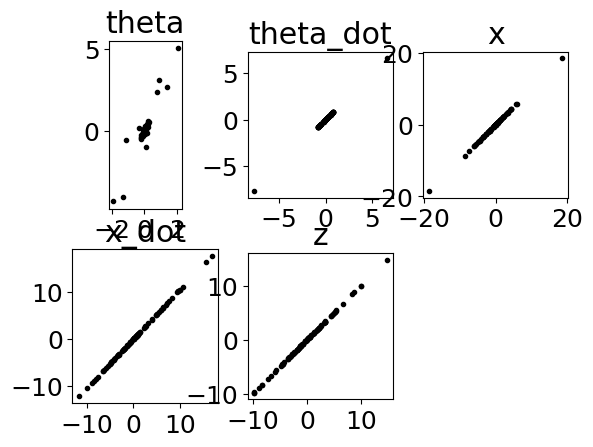

In [56]:
fig = plt.figure()

# pysindy inference is slow, so don't run on all of the data we have, just a subset is enough to get a sense.
N_points = 1000

for s in range(5):
  ax = fig.add_subplot(2,3,s+1)
  ax.set_aspect('equal')

  for k in range(0, N_points, 10):

    sindy_xdot = sindy_inference_model.predict(X[k:k+1,:], U[k:k+1,:])
    true_xdot = h(X[k,:], U[k,:])

    ax.plot(sindy_xdot[s], true_xdot[s], '.', color='black')
    ax.set_title(state_names[s])

# Exercises:

1. Try some of the other optimizers in pysindy:
  * STLSQ
  * SSR
2. Make the SINDy library more exhaustive
  * Note: to use MIOSR with a bigger library you will need to register for a gurobipy license (free for academic email on academic network).